In [49]:
import os, sys
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'
import numpy as np
import voxelmorph as vxm
import neurite as ne
import torch
import time

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [46]:
npz = np.load('/DATA/jakaria_data/CMPUT-617/data/oasis_mini/tutorial_data.npz')
x_train = npz['train']
x_val = npz['validate']

# the 208 volumes are of size 160x192
vol_shape = x_train.shape[1:]
print('train shape:', x_train.shape)

train shape: (208, 192, 160)


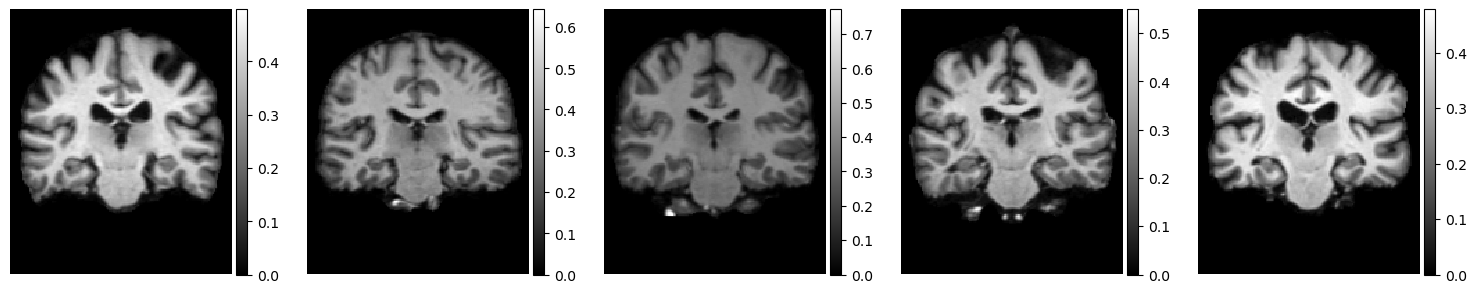

In [21]:
# extract some brains
nb_vis = 5
idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [151]:
# configure unet features 
nb_features = [
    [16, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16, 16]  # decoder features
]

# unet
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features)

# losses and loss weights
image_loss_func = vxm.losses.MSE().loss
losses = [image_loss_func]
weights = [1]
losses += [vxm.losses.Grad('l2', loss_mult=2).loss]
weights += [0.01]
print(os.environ['VXM_BACKEND'])

pytorch


In [152]:
vxm_model.to(device)
vxm_model.train()
optimizer=torch.optim.Adam(vxm_model.parameters(),lr=1e-4)

In [153]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

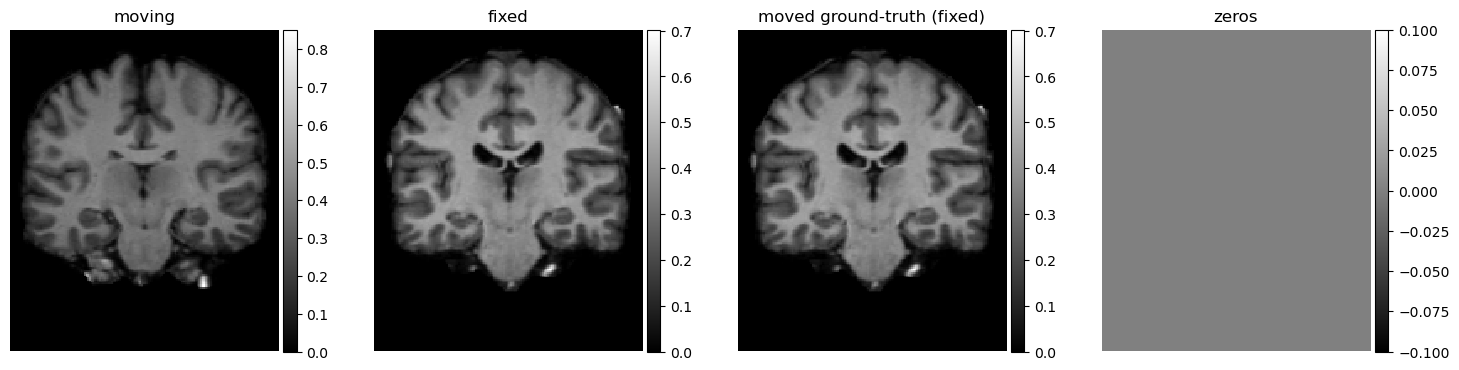

In [154]:
# let's test it
train_generator = vxm_data_generator(x_train, batch_size=8)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [155]:
inputs, y_true = next(train_generator)
for d in y_true:
    print(d.shape)
epochs = 500

(8, 192, 160, 1)
(8, 192, 160, 2)


In [156]:
# training loops
epochs = 500
for epoch in range(0, epochs):

    epoch_loss = []
    epoch_total_loss = []
    epoch_step_time = []

    for step in range(5):

        step_start_time = time.time()

        # generate inputs (and true outputs) and convert them to tensors
        inputs, y_true = next(train_generator)
        inputs = [torch.from_numpy(d).to(device).float().permute(0, 3, 1, 2) for d in inputs]
        y_true = [torch.from_numpy(d).to(device).float().permute(0, 3, 1, 2) for d in y_true]

        # run inputs through the model to produce a warped image and flow field
        y_pred = vxm_model(*inputs)

        # calculate total loss
        loss = 0
        loss_list = []
        for n, loss_function in enumerate(losses):
            curr_loss = loss_function(y_true[n], y_pred[n]) * weights[n]
            loss_list.append(curr_loss.item())
            loss += curr_loss

        epoch_loss.append(loss_list)
        epoch_total_loss.append(loss.item())

        # backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # get compute time
        epoch_step_time.append(time.time() - step_start_time)

    # print epoch info
    epoch_info = 'Epoch %d/%d' % (epoch + 1, 500)
    time_info = '%.4f sec/step' % np.mean(epoch_step_time)
    losses_info = ', '.join(['%.4e' % f for f in np.mean(epoch_loss, axis=0)])
    loss_info = 'loss: %.4e  (%s)' % (np.mean(epoch_total_loss), losses_info)
    print(' - '.join((epoch_info, time_info, loss_info)), flush=True)
vxm_model.save(os.path.join('/DATA/jakaria_data/CMPUT-617/saved_models', '%04d.pt' % epochs))

Epoch 1/500 - 0.0279 sec/step - loss: 7.0006e-03  (7.0006e-03, 9.6361e-12)
Epoch 2/500 - 0.0283 sec/step - loss: 6.9536e-03  (6.9536e-03, 9.0190e-11)
Epoch 3/500 - 0.0255 sec/step - loss: 7.6864e-03  (7.6864e-03, 2.9486e-10)
Epoch 4/500 - 0.0251 sec/step - loss: 6.9533e-03  (6.9533e-03, 7.0210e-10)
Epoch 5/500 - 0.0252 sec/step - loss: 7.2803e-03  (7.2803e-03, 1.4781e-09)
Epoch 6/500 - 0.0250 sec/step - loss: 7.1371e-03  (7.1371e-03, 3.0074e-09)
Epoch 7/500 - 0.0261 sec/step - loss: 6.8845e-03  (6.8845e-03, 6.0773e-09)
Epoch 8/500 - 0.0252 sec/step - loss: 7.1517e-03  (7.1517e-03, 1.2405e-08)
Epoch 9/500 - 0.0254 sec/step - loss: 6.7858e-03  (6.7858e-03, 2.6237e-08)
Epoch 10/500 - 0.0249 sec/step - loss: 7.3773e-03  (7.3772e-03, 5.9057e-08)
Epoch 11/500 - 0.0250 sec/step - loss: 6.9131e-03  (6.9129e-03, 1.4155e-07)
Epoch 12/500 - 0.0250 sec/step - loss: 7.1580e-03  (7.1576e-03, 3.6438e-07)
Epoch 13/500 - 0.0254 sec/step - loss: 6.9277e-03  (6.9267e-03, 1.0112e-06)
Epoch 14/500 - 0.0257

Epoch 109/500 - 0.0271 sec/step - loss: 4.2158e-03  (3.7615e-03, 4.5424e-04)
Epoch 110/500 - 0.0277 sec/step - loss: 4.9567e-03  (4.4656e-03, 4.9108e-04)
Epoch 111/500 - 0.0273 sec/step - loss: 4.3603e-03  (3.8757e-03, 4.8458e-04)
Epoch 112/500 - 0.0279 sec/step - loss: 4.8675e-03  (4.3607e-03, 5.0688e-04)
Epoch 113/500 - 0.0280 sec/step - loss: 5.1942e-03  (4.6694e-03, 5.2484e-04)
Epoch 114/500 - 0.0280 sec/step - loss: 4.5494e-03  (4.0701e-03, 4.7932e-04)
Epoch 115/500 - 0.0269 sec/step - loss: 4.6331e-03  (4.1658e-03, 4.6735e-04)
Epoch 116/500 - 0.0275 sec/step - loss: 4.7442e-03  (4.2801e-03, 4.6410e-04)
Epoch 117/500 - 0.0276 sec/step - loss: 4.6534e-03  (4.1454e-03, 5.0801e-04)
Epoch 118/500 - 0.0274 sec/step - loss: 4.3088e-03  (3.8558e-03, 4.5303e-04)
Epoch 119/500 - 0.0290 sec/step - loss: 5.1571e-03  (4.6524e-03, 5.0474e-04)
Epoch 120/500 - 0.0275 sec/step - loss: 4.4285e-03  (3.8985e-03, 5.2996e-04)
Epoch 121/500 - 0.0270 sec/step - loss: 4.4651e-03  (3.9990e-03, 4.6614e-04)

Epoch 216/500 - 0.0271 sec/step - loss: 4.3865e-03  (3.7858e-03, 6.0072e-04)
Epoch 217/500 - 0.0279 sec/step - loss: 4.4062e-03  (3.7510e-03, 6.5521e-04)
Epoch 218/500 - 0.0278 sec/step - loss: 4.4316e-03  (3.8262e-03, 6.0540e-04)
Epoch 219/500 - 0.0277 sec/step - loss: 4.1305e-03  (3.4899e-03, 6.4060e-04)
Epoch 220/500 - 0.0277 sec/step - loss: 4.4043e-03  (3.8144e-03, 5.8991e-04)
Epoch 221/500 - 0.0280 sec/step - loss: 4.3287e-03  (3.6558e-03, 6.7285e-04)
Epoch 222/500 - 0.0269 sec/step - loss: 4.5417e-03  (3.9339e-03, 6.0776e-04)
Epoch 223/500 - 0.0265 sec/step - loss: 4.0736e-03  (3.4884e-03, 5.8521e-04)
Epoch 224/500 - 0.0277 sec/step - loss: 4.1632e-03  (3.5453e-03, 6.1792e-04)
Epoch 225/500 - 0.0273 sec/step - loss: 4.3711e-03  (3.6995e-03, 6.7152e-04)
Epoch 226/500 - 0.0283 sec/step - loss: 4.7885e-03  (4.1179e-03, 6.7057e-04)
Epoch 227/500 - 0.0275 sec/step - loss: 4.5646e-03  (3.9292e-03, 6.3539e-04)
Epoch 228/500 - 0.0277 sec/step - loss: 4.6548e-03  (3.9136e-03, 7.4118e-04)

Epoch 323/500 - 0.0272 sec/step - loss: 4.2229e-03  (3.4893e-03, 7.3359e-04)
Epoch 324/500 - 0.0274 sec/step - loss: 3.8601e-03  (3.2520e-03, 6.0808e-04)
Epoch 325/500 - 0.0275 sec/step - loss: 4.4688e-03  (3.7093e-03, 7.5956e-04)
Epoch 326/500 - 0.0281 sec/step - loss: 4.1154e-03  (3.4666e-03, 6.4876e-04)
Epoch 327/500 - 0.0270 sec/step - loss: 4.2359e-03  (3.4877e-03, 7.4827e-04)
Epoch 328/500 - 0.0262 sec/step - loss: 4.0775e-03  (3.4212e-03, 6.5631e-04)
Epoch 329/500 - 0.0271 sec/step - loss: 4.0516e-03  (3.4251e-03, 6.2656e-04)
Epoch 330/500 - 0.0279 sec/step - loss: 3.7977e-03  (3.1753e-03, 6.2232e-04)
Epoch 331/500 - 0.0273 sec/step - loss: 4.0092e-03  (3.3287e-03, 6.8051e-04)
Epoch 332/500 - 0.0278 sec/step - loss: 4.4186e-03  (3.7580e-03, 6.6062e-04)
Epoch 333/500 - 0.0281 sec/step - loss: 4.2218e-03  (3.5607e-03, 6.6111e-04)
Epoch 334/500 - 0.0276 sec/step - loss: 3.7680e-03  (3.1576e-03, 6.1042e-04)
Epoch 335/500 - 0.0277 sec/step - loss: 4.2199e-03  (3.5506e-03, 6.6927e-04)

Epoch 430/500 - 0.0259 sec/step - loss: 4.4210e-03  (3.6320e-03, 7.8898e-04)
Epoch 431/500 - 0.0257 sec/step - loss: 3.8839e-03  (3.1889e-03, 6.9495e-04)
Epoch 432/500 - 0.0259 sec/step - loss: 3.9340e-03  (3.2624e-03, 6.7153e-04)
Epoch 433/500 - 0.0256 sec/step - loss: 4.7126e-03  (3.9239e-03, 7.8876e-04)
Epoch 434/500 - 0.0256 sec/step - loss: 4.3285e-03  (3.5735e-03, 7.5498e-04)
Epoch 435/500 - 0.0261 sec/step - loss: 4.2051e-03  (3.4496e-03, 7.5547e-04)
Epoch 436/500 - 0.0257 sec/step - loss: 4.4375e-03  (3.6406e-03, 7.9696e-04)
Epoch 437/500 - 0.0257 sec/step - loss: 4.0967e-03  (3.3280e-03, 7.6869e-04)
Epoch 438/500 - 0.0259 sec/step - loss: 4.4147e-03  (3.6337e-03, 7.8103e-04)
Epoch 439/500 - 0.0256 sec/step - loss: 4.0400e-03  (3.3368e-03, 7.0314e-04)
Epoch 440/500 - 0.0254 sec/step - loss: 3.9428e-03  (3.1985e-03, 7.4437e-04)
Epoch 441/500 - 0.0262 sec/step - loss: 3.7423e-03  (3.0629e-03, 6.7939e-04)
Epoch 442/500 - 0.0250 sec/step - loss: 4.3680e-03  (3.6371e-03, 7.3088e-04)

In [305]:
# create the validation data generator
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)

In [306]:
for i in val_input:
    print(i.shape)

(1, 192, 160, 1)
(1, 192, 160, 1)


In [307]:
inputs = [torch.from_numpy(d).to(device).float().permute(0, 3, 1, 2) for d in val_input]

In [308]:
model = vxm.networks.VxmDense.load(os.path.join('/DATA/jakaria_data/CMPUT-617/saved_models', '%04d.pt' % epochs), device)
model.to(device)
print("loaded")

loaded


In [309]:
moved, warp = model(*inputs, registration=True)

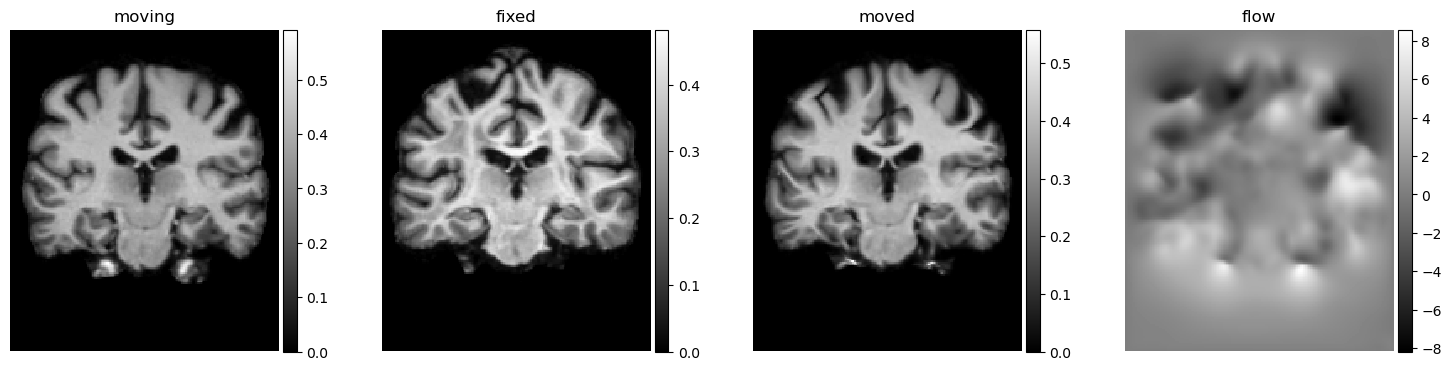

In [310]:
# visualize registration
predicted_output = [moved.detach().cpu().permute(0,2,3,1).numpy(), warp.detach().cpu().permute(0,2,3,1).numpy()]
images = [img[0, :, :, 0] for img in val_input + predicted_output] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

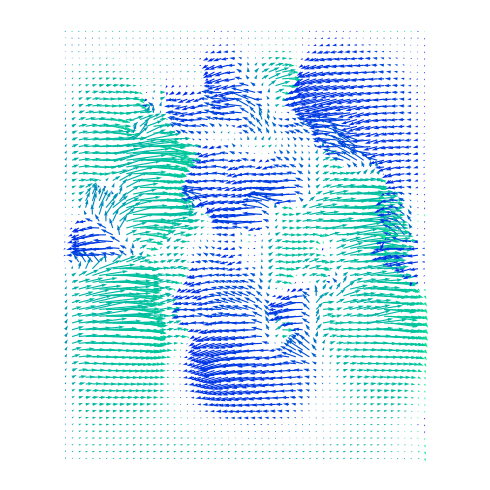

In [199]:
# visualize flow
flow = predicted_output[1].squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

In [213]:
val_volume_1 = np.load('/DATA/jakaria_data/CMPUT-617/data/oasis_mini/subj1.npz')['vol']
seg_volume_1 = np.load('/DATA/jakaria_data/CMPUT-617/data/oasis_mini/subj1.npz')['seg']
val_volume_2 = np.load('/DATA/jakaria_data/CMPUT-617/data/oasis_mini/subj2.npz')['vol']
seg_volume_2 = np.load('/DATA/jakaria_data/CMPUT-617/data/oasis_mini/subj2.npz')['seg']

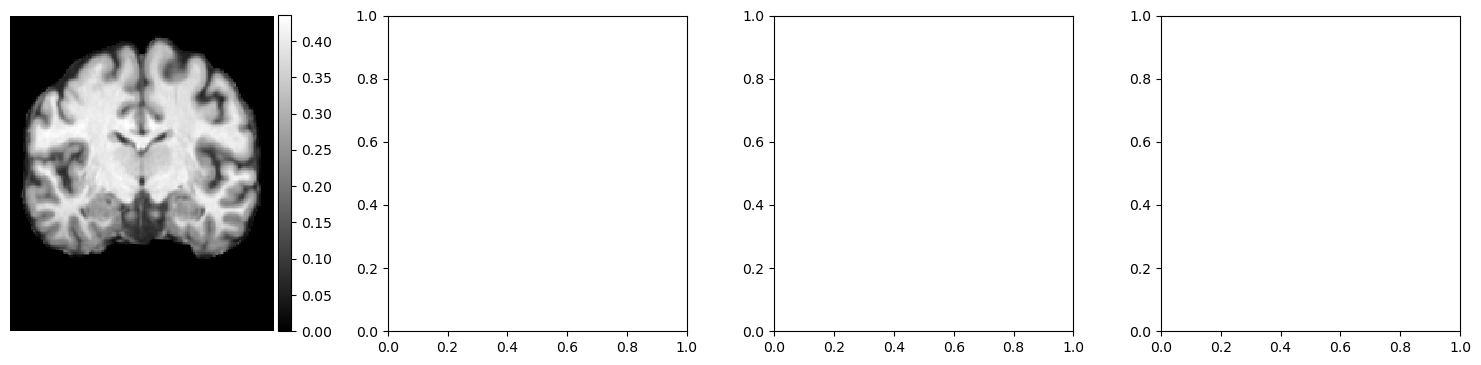

In [215]:
vol_shape = (160, 192, 224)
mid_slices_fixed = np.take(val_volume_1, vol_shape[2]//2, axis=2)
mid_slices_fixed = np.rot90(mid_slices_fixed, -1)
ne.plot.slices(mid_slices_fixed, cmaps=['gray'], do_colorbars=True, grid=[1,4]);

In [271]:
new_volume_1 = []
for i in range(100, 124):
    fixed = np.take(val_volume_1, i, axis=2)
    fixed = np.rot90(fixed, -1)
    new_volume_1.append(fixed)

In [312]:
new_volume_2 = []
for i in range(100, 124):
    fixed = np.take(val_volume_2, i, axis=2)
    fixed = np.rot90(fixed, -1)
    new_volume_2.append(fixed)

In [313]:
new_volume_1 = np.array(new_volume_1)
print(new_volume_1.shape)
new_volume_2 = np.array(new_volume_2)
print(new_volume_1.shape)

(24, 192, 160)
(24, 192, 160)


In [378]:
new_seg_1 = []
for i in range(100, 124):
    fixed = np.take(seg_volume_1, i, axis=2)
    #fixed = np.rot90(fixed, -1)
    new_seg_1.append(fixed)

In [379]:
new_seg_2 = []
for i in range(100, 124):
    fixed = np.take(seg_volume_2, i, axis=2)
    #fixed = np.rot90(fixed, -1)
    new_seg_2.append(fixed)

In [380]:
new_seg_1 = np.array(new_seg_1)
print(new_seg_1.shape)
new_seg_2 = np.array(new_seg_2)
print(new_seg_2.shape)

(24, 160, 192)
(24, 160, 192)


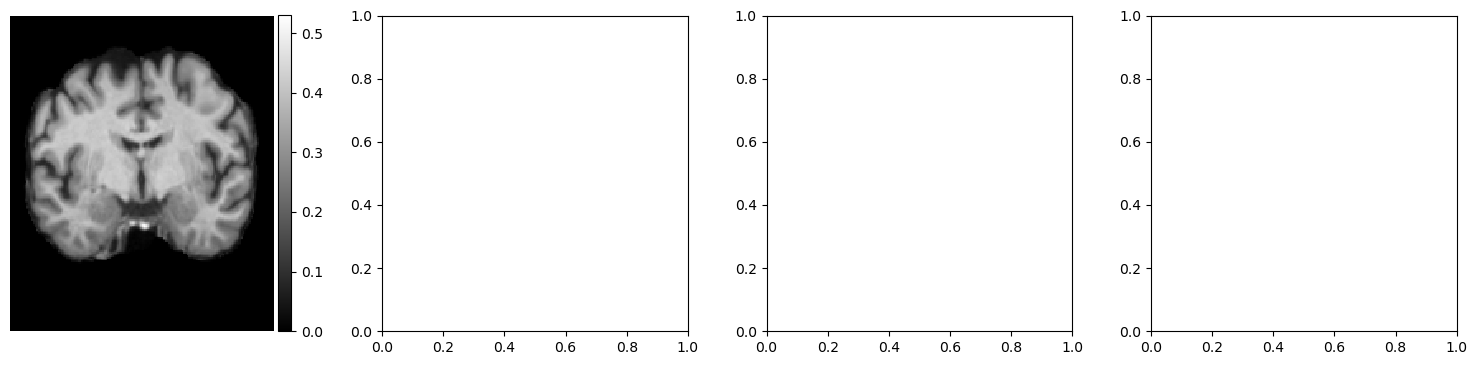

In [316]:
ne.plot.slices(new_volume_1[20], cmaps=['gray'], do_colorbars=True, grid=[1,4]);

In [279]:
# Data generator with segment masks
def vxm_data_generator_w_segment(x_data, segmentations, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        seg1 = segmentations[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        seg2 = segmentations[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        seg = [seg1, seg2]
        
        yield (inputs, outputs, seg)

In [392]:
# create the validation data generator
#val_generator_seg = vxm_data_generator_w_segment(new_volume_1, new_seg_1, batch_size = 1)
#val_input, _, seg = next(val_generator_seg)
moving = new_volume_1[12]
fixed = new_volume_2[12]
val_input = [moving[np.newaxis, ..., np.newaxis], fixed[np.newaxis, ..., np.newaxis]]
moving_seg = new_seg_1[12]
fixed_seg = new_seg_2[12]
val_seg = [moving_seg[np.newaxis, ..., np.newaxis], fixed_seg[np.newaxis, ..., np.newaxis]]

In [382]:
for i in val_seg:
    print(i.shape)

(1, 160, 192, 1)
(1, 160, 192, 1)


In [334]:
inputs = [torch.from_numpy(d).to(device).float().permute(0, 3, 1, 2) for d in val_input]

In [335]:
moved, warp = model(*inputs, registration=True)

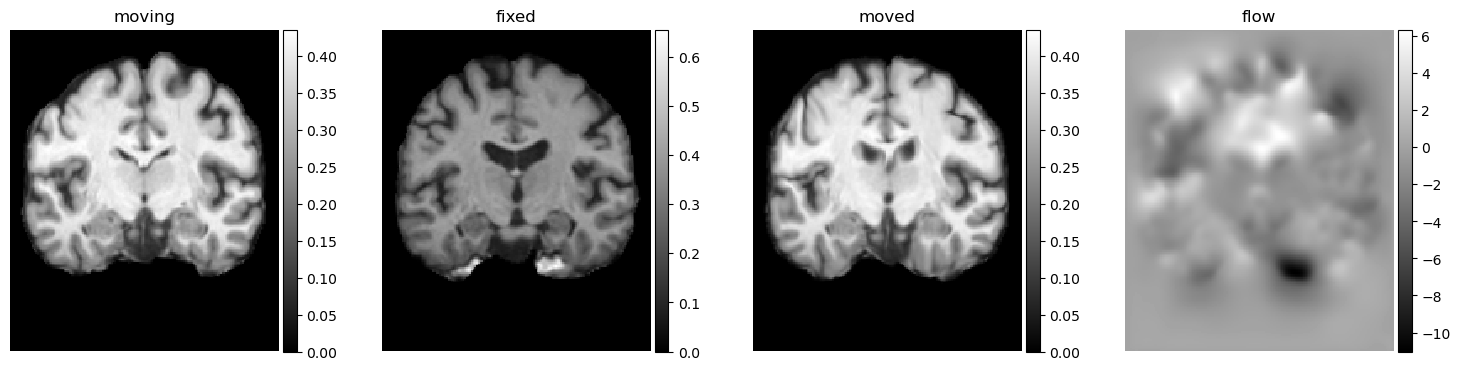

In [336]:
# visualize registration
predicted_output = [moved.detach().cpu().permute(0,2,3,1).numpy(), warp.detach().cpu().permute(0,2,3,1).numpy()]
images = [img[0, :, :, 0] for img in val_input + predicted_output] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

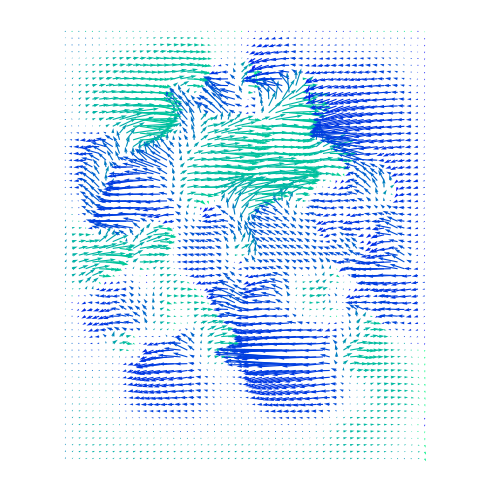

In [337]:
# visualize flow
flow = predicted_output[1].squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

In [383]:
from pystrum.pytools.plot import jitter
import matplotlib

[ccmap, scrambled_cmap] = jitter(255, nargout=2)
scrambled_cmap[0, :] = np.array([0, 0, 0, 1])
ccmap = matplotlib.colors.ListedColormap(scrambled_cmap)

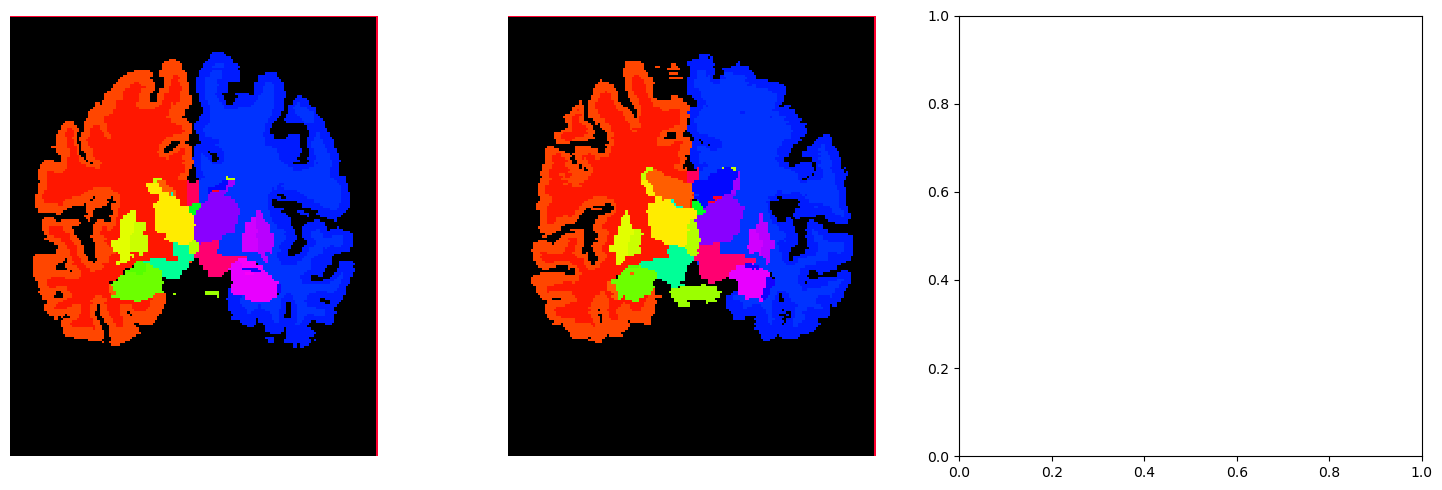

(192, 160)

In [393]:
val_seg = [val_seg[0][0,:,:,0], val_seg[1][0,:,:,0]]
val_seg[0] = np.rot90(val_seg[0], -1)
val_seg[1] = np.rot90(val_seg[1], -1)
slices = val_seg
for si, slc  in enumerate(slices):
    slices[si][0] = 255
ne.plot.slices(slices, cmaps = [ccmap], grid=[1,3]);
slices[1].shape

In [361]:
slices[2].shape

(192, 160)

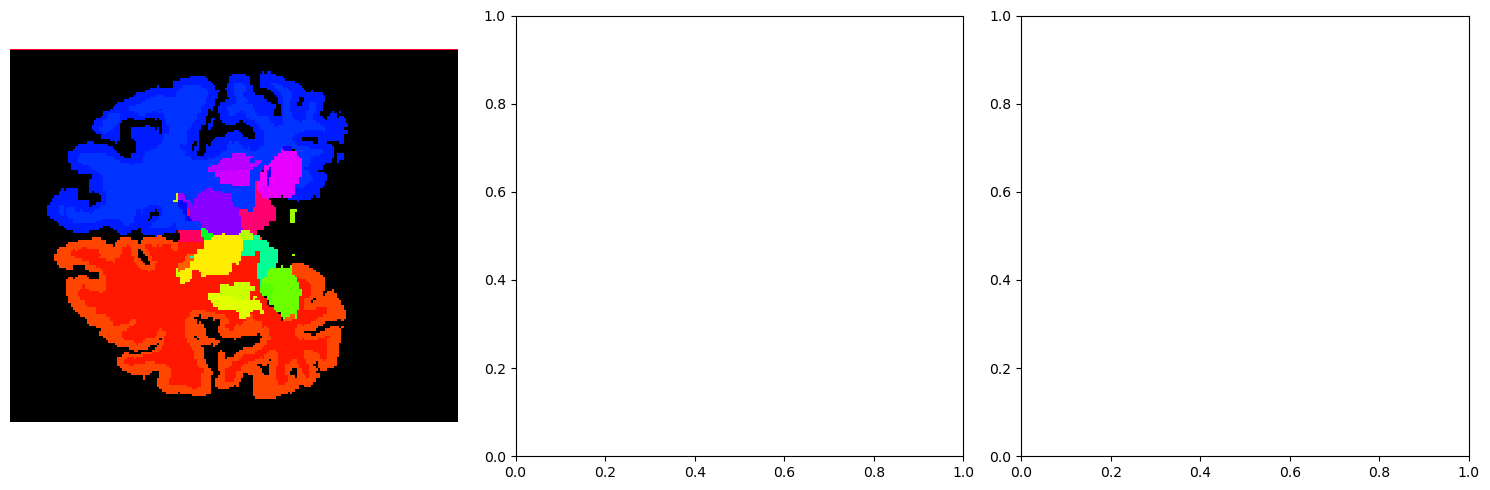

In [377]:
mid_slices_fixed = [np.take(seg_volume_1, 112, axis=2)]
#mid_slices_fixed = np.rot90(mid_slices_fixed, -1)

slices = mid_slices_fixed
for si, slc  in enumerate(slices):
    slices[si][0] = 255
ne.plot.slices(slices, cmaps = [ccmap], grid=[1,3]);